In [64]:
# prerequisite package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import folium
from folium import plugins
from folium.plugins import HeatMap
import datetime as datetime

%matplotlib inline

In [65]:
# load data set and make a copy
bikes = pd.read_csv('bikes_master.csv')
bikes_copy = bikes.copy()

In [67]:
# cleaning operations
# create duration in mins column
bikes_copy['duration_min'] = bikes_copy['duration_sec']/60
bikes_copy.duration_min.describe()
# change data type to datetime
bikes_copy['start_time'] = pd.to_datetime(bikes_copy['start_time'])
# rearrange columns for personal preference
bikes_copy = bikes_copy[['duration_sec', 'duration_min', 'start_time', 'end_time', 'start_station_id',
       'start_station_name',  'end_station_id', 'end_station_name', 'bike_id', 'user_type', 'member_birth_year', 
        'member_gender', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude',
                          'bike_share_for_all_trip']]
# reduce rides lasting more than 6 hours
bikes_copy = bikes_copy.query("duration_min < 360")
# create age column
bikes_copy['age'] = 2018 - bikes_copy['member_birth_year']
# filter for gps location (inside SF)
bikes_copy = bikes_copy.query("start_station_latitude >= 37.707000 and start_station_latitude < 37.8100000 and start_station_longitude > -122.51000 and start_station_longitude <= -122.3700000")
bikes_copy = bikes_copy.query("end_station_latitude >= 37.707000 and end_station_latitude < 37.8100000 and end_station_longitude > -122.51000 and end_station_longitude <= -122.3700000")

In [68]:
# create a large sample of data for faster processing time 1.3 million rows is a lot
sf_bikes = bikes_copy.sample(100000, replace=True)

## User Types as a Proportion

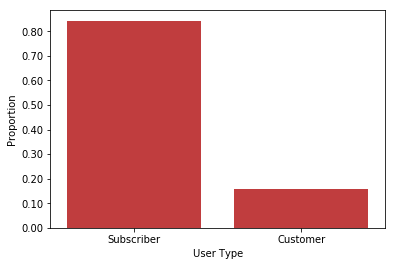

In [69]:
n_points = sf_bikes.shape[0]
max_count = sf_bikes['user_type'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop+0.1, 0.10)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
base_color = sb.color_palette()[3]
plt.yticks(tick_props * n_points, tick_names)
sb.countplot(data = sf_bikes, x = 'user_type', color = base_color)
plt.ylabel('Proportion')
plt.xlabel('User Type');

## Usage Throughout the Day

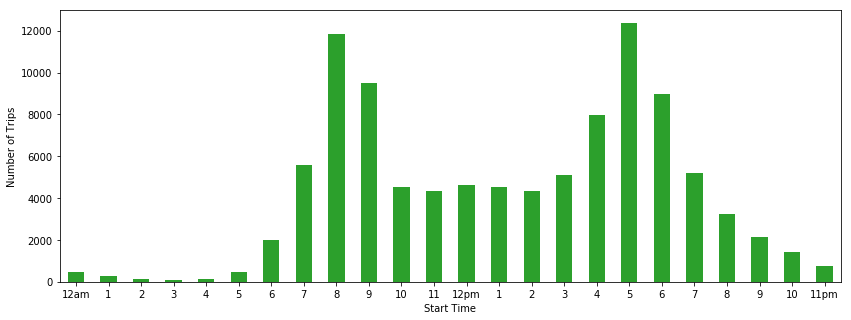

In [70]:
plt.figure(figsize = (14,5))
base_color = sb.color_palette()[2]
# hours = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
#         '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']
hours = ['12am', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
        '12pm', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11pm']
sf_bikes.groupby(sf_bikes.start_time.dt.hour).bike_id.count().plot(kind='bar', color = base_color);
# get the plot axes information
ax = plt.gca()
# get xtick positions
pos = ax.get_xticks().tolist()
# get xtick labels
labs = ax.get_xticklabels()
# change the xticks
plt.xticks(pos,hours, rotation = 'horizontal')
plt.xlabel('Start Time')
plt.ylabel('Number of Trips');

## Usage by Month

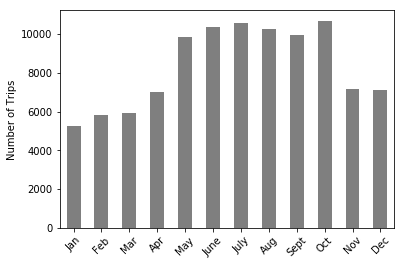

In [71]:
base_color = sb.color_palette()[7] 
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
sf_bikes.groupby(sf_bikes.start_time.dt.month).bike_id.count().plot(kind='bar', color = base_color)
# get the plot axes information
ax = plt.gca()
# get xtick positions
pos = ax.get_xticks().tolist()
# get xtick labels
labs = ax.get_xticklabels()
# change the xticks
plt.xticks(pos,months, rotation = '45')
plt.xlabel('')
plt.ylabel('Number of Trips');

## Heat Map of Trip Duration by Age

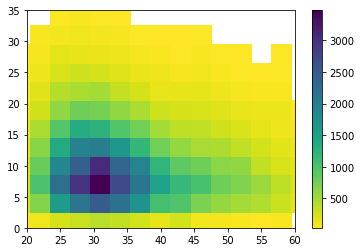

In [72]:
bins_x = np.arange(17.5, 70.5+3, 3)
bins_y = np.arange(-0.5, 100.5+3, 3)
plt.hist2d(data = sf_bikes, x = 'age', y = 'duration_min',
           bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 35)
plt.colorbar()
plt.xlim(20, 60)
plt.ylim(0, 35);

## Subscription Type Difference Clearly Illustrated by Trip Duration Spread

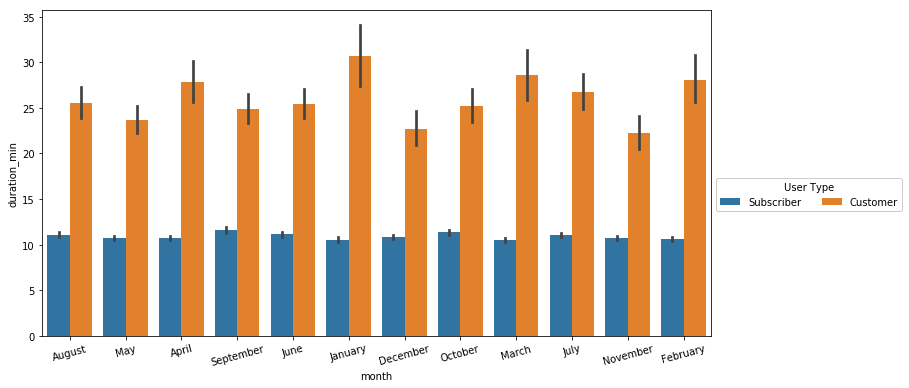

In [77]:
sf_bikes['month'] = sf_bikes.start_time.dt.strftime("%B")
plt.figure(figsize = (12, 6))
ax = sb.barplot(data = sf_bikes, x = 'month', y = 'duration_min', hue = 'user_type')
ax.legend(loc = 0, ncol = 3, framealpha = 1, title = 'User Type', bbox_to_anchor = (1.0, 0.5));
plt.xticks(rotation = 15);

## AM Commute Last Mile Conveyed by Heat Map

In [78]:
# AM commute 7am to 10am
AM = sf_bikes.query("start_time.dt.hour >= 7 and start_time.dt.hour <= 10")

# PM commute 3pm to 6pm
PM = sf_bikes.query("start_time.dt.hour >= 15 and start_time.dt.hour <= 18")

In [79]:
bikes_short = AM.sample(3000, replace=True)

# grab image of SF map
sf = folium.Map(location=[37.775204, -122.418747],
                    zoom_start = 13) 
# build df to plug into heatmap func from sampled data to make processing faster
heat_df = bikes_short[['start_station_latitude', 'start_station_longitude']]
heat_df = bikes_short.dropna(axis=0, subset=['start_station_latitude', 'start_station_longitude'])

# List comprehension to make out list of lists
heat_data = [[row['start_station_latitude'],row['start_station_longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(sf)

# Display the map
sf

In [81]:
# sample smaller set for easier loading
AM_end = AM.sample(3000, replace=True)

# grab image of SF map
sf = folium.Map(location=[37.775204, -122.418747], zoom_start = 13) 
# build df to plug into heatmap func from sampled data to make processing faster
heat_df = AM_end[['end_station_latitude', 'end_station_longitude']]
heat_df = AM_end.dropna(axis=0, subset=['end_station_latitude', 'end_station_longitude'])
# List comprehension to make out list of lists
heat_data = [[row['end_station_latitude'],row['end_station_longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map and display
HeatMap(heat_data).add_to(sf)
sf